In [383]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.integrate import quad
plt.rc('animation', html='jshtml')

In [384]:
class Box():
    def __init__(self, y, dydx, qinit, times) -> None:
        self.my_sol = None
        self.ode_solved = False
        self.qinit = qinit.copy()
        self.qs = {}
        for i in range(len(self.qinit)):
            self.qs[f"q{i}"] = []
        self.y = y
        self.dydx = dydx
        self.times = times.copy()
        self.drawing_elements = {}
        self.dqdt = None
        self.axs_added = 0
        self.col = "C0"

    def solve_ode(self):
        y_init = self.y(self.qinit[0])
        if self.dqdt == None:
            raise Exception("No differential equation has been supplied yet")
        if self.ode_solved == False:
            my_sol = solve_ivp(self.dqdt,[self.times[0],self.times[-1]], self.qinit, t_eval=self.times, args=[y_init+0.01])
            self.ode_solved = True
            for i, sol in enumerate(my_sol.y):
                self.qs[f"q{i}"] = sol.copy()
        else:
            raise Exception("Differential equation has already been solved for the specified times")
        

    def update_times(self, new_times):
        self.times = new_times.copy()
        self.ode_solved == False
    
    def update_plot_elements(self, ax, t_index):
        self.coord = self.drawing_elements[ax][0]
        if self.coord == "q0":
            if len(self.drawing_elements[ax]) == 1:
                ball = ax.plot(self.qs[self.coord][0], self.y(self.qs[self.coord][0]), 'o', color=self.col, ms=7, markeredgecolor="k")[0]
                self.drawing_elements[ax].append(ball)
            else:
                self.drawing_elements[ax][1].set_data(self.qs[self.coord][t_index], self.y(self.qs[self.coord][t_index]))
            
        if self.coord == "q1":
            if len(self.drawing_elements[ax]) == 1:
                ball = ax.plot(self.times[0], self.qs[self.coord][0], 'o', color=self.col, ms=7, markeredgecolor="k")[0]
                self.drawing_elements[ax].append(ball)
            else:
                self.drawing_elements[ax][1].set_data(self.times[t_index], self.qs[self.coord][t_index])

    def find_xt(self, t):
        self.index = np.where(self.times == t)[0]
        if len(self.index) == 0:
            return 0
        else:
            return self.index[0]

    def draw(self, ax, t):
        if t in self.times:
            if ax in self.drawing_elements:
                pass
            else:
                self.drawing_elements[ax] = [f"q{self.axs_added}"].copy()
                self.axs_added+=1
            
            if self.ode_solved == True:
                t_index = self.find_xt(t=t)
                self.update_plot_elements(ax=ax, t_index=t_index)
            else:
                self.solve_ode()
                t_index = self.find_xt(t=t)
                self.update_plot_elements(ax=ax, t_index=t_index)
        else:
            raise Exception("t is not within the specified times, so will not be calculated")
        
        return self.drawing_elements[ax][1::]

In [385]:
def dydx(f, x, deltax=1e-5):
    y1 = f(x)
    y2 = f(x+deltax)
    return (y2-y1)/deltax

def lin_ramp(x, width=30):
    y0=22.5
    a = -y0/width
    return a*x + y0
    
def phi_solve(x_input, a):
    x = x_input
    if type(x) == float or type(x) == np.float64: #Kludret fix, men gør jobbet
        f1 = lambda phi: a*(phi-np.sin(phi))-x
        phi = fsolve(f1, 3.0)[0]
        return phi
    if type(x) != float and type(x) != np.float64:
        phis = np.zeros(len(x_input))
        for i, x_val in enumerate(x):
            f1 = lambda phi: a*(phi-np.sin(phi))-x_val
            phi = fsolve(f1, 3.0)[0]
            phis[i] = phi
        return phis

def tauto_curve(x, r=20.0, y0=40.0):
    phi = phi_solve(x_input=x, a=r)
    y1 = -r*(1.0-np.cos(phi)) + y0
    return y1

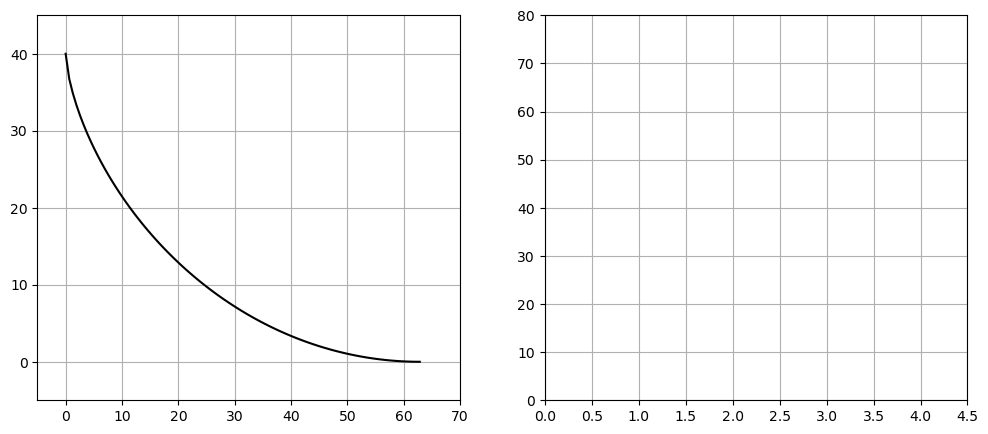

In [386]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
x0 = 0.0
xf = 20.0*np.pi#30#20.0*np.pi
xs = np.linspace(x0, xf, 100)
ys = tauto_curve(xs)#lin_ramp(xs)
axs[0].plot(xs, ys, c="k")
axs[0].grid()
axs[1].set_xlim([0,4.5])
axs[1].set_ylim([0.0,80])
axs[1].grid()
axs[0].set_xlim([-5.0, 70.0])
axs[0].set_ylim([-5.0, 45.0])
x_inits = [0.0, 10.0, 15.0, 30.0, 50.0]
#axs[0].plot(0.0, tauto_curve(0.0), "o")
#axs[0].plot(10.0, tauto_curve(10.0), "o")

In [387]:
def S(x):
    dy_dx = dydx(tauto_curve, x=x)
    #dy_dx = dydx(lin_ramp, x=x)
    return np.sqrt(1.0 + dy_dx**2)

In [388]:
times = np.arange(0.0,4.4,0.1)

colors = ["blue", "red", "green", "yellow", "orange"]
x_inits = [0.0, 10.0, 15.0, 30.0, 50.0]
y_inits = []
S_inits = []
for x_init in x_inits:
    s = quad(S, 0.0, x_init)
    S_inits.append(s[0])

def dqdt(t, q, y_x, dy_dx, y0=22.5, g=9.8):
    x = q[0]
    t1 = np.sqrt(2.0*g)*np.sqrt(y0-y_x(x))
    t2 = 1.0/np.sqrt(1+dy_dx(y_x, x)**2)
    return [t1*t2, t1]


boxes = []
for x_init, s_init, color in zip(x_inits, S_inits, colors):
    qinit = np.array([x_init, s_init])
    y_init = tauto_curve(x_init)#lin_ramp(x_init)#tauto_curve(x_init)
    print(y_init)
    #print(y_init-tauto_curve(x_init))
    box = Box(y=tauto_curve, dydx=dydx, qinit=qinit, times=times)
    box.dqdt = lambda t, q, y0: dqdt(t, q, y_x=tauto_curve, dy_dx=dydx, y0=y0)
    box.col = color
    #print(tauto_curve(x_init)+0.1
    boxes.append(box)

40.0
21.46859577953628
16.70441590050538
7.171171384329497
1.0380989577424913


In [389]:
def update(i):
    t = times[i]
    updated_drawing_elements = []
    for box in boxes:
        for ax in axs:
            elements = box.draw(ax,t)
            updated_drawing_elements+=elements
    return updated_drawing_elements

N = len(times)
anim = animation.FuncAnimation(fig, #Vi laver en animation over alle tidselementerne fra vores diff. ligning løsning
                               update,
                               frames=N,
                               interval=75,
                               blit=True)
anim

C:\Users\karst\AppData\Local\Temp\ipykernel_8460\3539859593.py:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self.drawing_elements[ax][1].set_data(self.qs[self.coord][t_index], self.y(self.qs[self.coord][t_index]))
C:\Users\karst\AppData\Local\Temp\ipykernel_8460\3539859593.py:41: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self.drawing_elements[ax][1].set_data(self.qs[self.coord][t_index], self.y(self.qs[self.coord][t_index]))


In [378]:
print(times)
print(boxes[0].qs)
print(boxes[1].drawing_elements)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3]
{'q0': array([0.00000000e+00, 3.15468753e-03, 1.64345543e-02, 4.66040996e-02,
       1.00356911e-01, 1.84339481e-01, 3.04890722e-01, 4.68453285e-01,
       6.80903071e-01, 9.48044882e-01, 1.27569896e+00, 1.66904028e+00,
       2.13262414e+00, 2.67113251e+00, 3.28915009e+00, 3.99062709e+00,
       4.77886956e+00, 5.65653938e+00, 6.62580837e+00, 7.68904547e+00,
       8.84827104e+00, 1.01048934e+01, 1.14597087e+01, 1.29129011e+01,
       1.44640426e+01, 1.61120931e+01, 1.78554173e+01, 1.96924556e+01,
       2.16212624e+01, 2.36392901e+01, 2.57435976e+01, 2.79308506e+01,
       3.01973217e+01, 3.25388902e+01, 3.49510422e+01, 3.74288705e+01,
       3.99670748e+01, 4.25599614e+01, 4.52014435e+01, 4.78850412e+01,
       5.06039170e+01, 5.33520998e+01, 5.61233896e+01, 5.89110738e+01]), 'q1': array([ 0.        ,  0.0